Reference: https://www.geeksforgeeks.org/nlp/amazon-product-reviews-sentiment-analysis-in-python/


In [1]:
!pip install datasets
from datasets import load_dataset

In [2]:
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import nltk
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import torch
import pickle
from datetime import datetime
import json


# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize once for all processes
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
categories = [
    "All_Beauty",
    "Amazon_Fashion",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Beauty_and_Personal_Care",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Clothing_Shoes_and_Jewelry",
    "Digital_Music",
    "Electronics",
    "Gift_Cards",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health_and_Household",
    "Health_and_Personal_Care",
    "Home_and_Kitchen",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Magazine_Subscriptions",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Subscription_Boxes",
    "Tools_and_Home_Improvement",
    "Toys_and_Games",
    "Video_Games",
    "Unknown"
]

In [4]:
def clean_text(text):
    """
    Clean and preprocess text data
    - Convert to lowercase
    - Tokenize into words
    - Remove stopwords, punctuation, non-alphabetic tokens
    - Lemmatize words
    """
    text = text.lower().strip()
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w not in stop_words and w not in string.punctuation and w.isalpha()
    ]
    return cleaned_tokens

In [ ]:
# load data of all categories; store in the form that includes: category, reviews and sentiment level (1-5)

# we load 5000 reviews from each category, then randomly sample 500 reviews for each category
def process_category(category, sample_size=500, reservoir_size=5000):
    """ return a dictionary with the structue: {"category":[
      {"category":[name],"tokens":[......], "rating":[1]},{...}
      ]}"""
    try:

      # load the data from hugging face
        data_url = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/{category}.jsonl"

        dataset = load_dataset("json", data_files=data_url, split="train", streaming=True)

        raw_rows = []
        for i, row in enumerate(dataset):
            if i >= reservoir_size:
                break

            raw_rows.append({
                'text': row.get('text', ''),
                'rating': row.get('rating', row.get('overall', None)),
                'title': row.get('title', ''),
                'images': row.get('images', []),
                'verified_purchase': row.get('verified_purchase', False),
                'asin': row.get('asin', ''),
                'parent_asin': row.get('parent_asin', ''),
                'user_id': row.get('user_id', ''),
                'timestamp': row.get('timestamp', None),
                'helpful_vote': row.get('helpful_vote', 0)
            })

        # set a seed for randomization
        random.seed(42)
        sampled_rows = random.sample(raw_rows, min(sample_size, len(raw_rows)))

        # clean the data: tokenize each review
        processed_data = []
        for row in sampled_rows:
            tokens = clean_text(row['text'])
            title = row['title'].lower().strip()
            time = datetime.fromtimestamp(row['timestamp']/ 1000)

            if tokens:
                processed_data.append({
                    'category': category,
                    'tokens': tokens,
                    'rating': row['rating'],
                    'original_text': row['text'],
                    'title': title,
                    'images': row['images'],
                    'verified_purchase': row['verified_purchase'],
                    'asin': row['asin'],
                    'parent_asin': row['parent_asin'],
                    'user_id': row['user_id'],
                    'datetime': time,
                    'helpful_vote': row['helpful_vote']
                })

        print(f"{category}: {len(processed_data)} reviews processed")
        return category, processed_data

    except Exception as e:
        print(f"{category}: Error - {str(e)}")
        return category, []
#

In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# execute
category_collection = {}

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(process_category, cat): cat for cat in categories}
    for future in as_completed(futures):
        cat, data_list = future.result()
        category_collection[cat] = data_list

Appliances: 499 reviews processed
Amazon_Fashion: 500 reviews processed
All_Beauty: 500 reviews processed
Arts_Crafts_and_Sewing: 499 reviews processed
Automotive: 498 reviews processed
Baby_Products: 499 reviews processed
Beauty_and_Personal_Care: 500 reviews processed
Books: 500 reviews processed
CDs_and_Vinyl: 500 reviews processed
Cell_Phones_and_Accessories: 494 reviews processed
Digital_Music: 498 reviews processed
Clothing_Shoes_and_Jewelry: 500 reviews processed
Gift_Cards: 494 reviews processed
Electronics: 494 reviews processed
Grocery_and_Gourmet_Food: 500 reviews processed
Handmade_Products: 499 reviews processed
Health_and_Personal_Care: 500 reviews processed
Health_and_Household: 500 reviews processed
Home_and_Kitchen: 500 reviews processed
Industrial_and_Scientific: 497 reviews processed
Kindle_Store: 500 reviews processed
Magazine_Subscriptions: 499 reviews processed
Movies_and_TV: 500 reviews processed
Musical_Instruments: 500 reviews processed
Office_Products: 499 rev

In [ ]:
final_list = []
for cat, items in category_collection.items():
    for item in items:
        final_list.append({
            'category': item['category'],
            'rating': item['rating'],
            'tokens': item['tokens'],
            'text_cleaned': ' '.join(item['tokens']),
            'original_text': item['original_text'],
            'token_count': len(item['tokens']),
            'title': item['title'],
            'images': item['images'],
            'verified_purchase': item['verified_purchase'],
            'asin': item['asin'],
            'parent_asin': item['parent_asin'],
            'user_id': item['user_id'],
            'datetime': item['datetime'],
            'helpful_vote': item['helpful_vote']
        })

df = pd.DataFrame(final_list)

In [ ]:
df.head()

,category,rating,sentiment,tokens,text_cleaned,original_text,token_count,title,images,verified_purchase,asin,parent_asin,user_id,datetime,helpful_vote
0,Appliances,5.0,positive,"[exelent, save, coffee, water, waste, easy, cl...",exelent save coffee water waste easy clean act...,"Exelent, save on coffee, water, no waste, e...",14,savings,[],True,B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,2017-10-16 22:46:40.529,0
1,Appliances,5.0,positive,"[ordered, wrong, part, quality, part, seemed, ...",ordered wrong part quality part seemed good,Ordered wrong part but the quality of this par...,7,check part numbers,[],True,B094YWPF68,B094YWPF68,AEU2V36H3G45EFVLASUPD56B7ATQ,2021-08-30 19:50:53.564,0
2,Appliances,5.0,positive,[described],described,as described,1,five stars,[],True,B00LQL043A,B00LQL043A,AE7FJMYY4AKWBDASLTMMQ5WASB7A,2016-09-28 15:08:18.000,0
3,Appliances,5.0,positive,"[used, replace, broken, door, bin, back, ice, ...",used replace broken door bin back ice dispense...,Used to replace a broken door bin on the back ...,18,fits,[],True,B00C29G3N0,B00C29G3N0,AGM4WN3EOAA3RUAUXGH2S2AUL6WA,2019-01-06 21:01:13.614,3
4,Appliances,5.0,positive,"[husband, us, broke, cleaning, replace, well, ...",husband us broke cleaning replace well say one...,My husband uses these. I broke it when cleanin...,35,easy peasy to use and clean.,[],True,B01DP1IWKU,B092LLM7H3,AEBXJRP4COCKP22LPKUDVCQ7JKVQ,2019-08-09 02:13:50.975,0


In [ ]:
df.to_parquet('amazon_user_reviews.parquet', index=False)

In [ ]:
# load meta data of all categories

# we load 5000 reviews from each category, then randomly sample 500 reviews for each category
def process_meta(category, sample_size=500, reservoir_size=5000):
    """ return a dictionary with the structue: {"category":[
      {"category":[name],"tokens":[......], "rating":[1]},{...}
      ]}"""
    try:

      # load the data from hugging face
        data_url = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/meta_categories/meta_{category}.jsonl"

        dataset = load_dataset("json", data_files=data_url, split="train", streaming=True)

        raw_rows = []
        for i, row in enumerate(dataset):
            if i >= reservoir_size:
                break

            raw_rows.append({
                'main_category': category,
                'title': row.get('title', ''),
                'average_rating': row.get('average_rating', None),
                'rating_number': row.get('rating_number', None),
                'features': row.get('features', []),
                'description': row.get('description', ''),
                'price': row.get('price', None),
                'images': row.get('images', []),
                'videos': row.get('videos', []),
                'store': row.get('store', ''),
                'categories': row.get('categories', []),
                'details': row.get('details', {}),
                'parent_asin': row.get('parent_asin', ''),
                'user_id': row.get('user_id', ''),
                'boughts_together': row.get('boughts_together', [])
            })

        # set a seed for randomization
        random.seed(42)
        sampled_rows = random.sample(raw_rows, min(sample_size, len(raw_rows)))

        # clean the data: tokenize each review
        processed_data = []

        # check columns with list of string
        for row in sampled_rows:
          # ensure description is a list of strings
          description_raw = row.get('description', '')
          if isinstance(description_raw, str):
              description_list = [description_raw] if description_raw else []
          elif isinstance(description_raw, list):
              description_list = [d for d in description_raw if isinstance(d, str)]
          else:
              description_list = []

          # ensure features is a list of strings
          features_raw = row.get('features', [])
          if isinstance(features_raw, str):
              features_list = [features_raw] if features_raw else []
          elif isinstance(features_raw, list):
              features_list = [f for f in features_raw if isinstance(f, str)]
          else:
              features_list = []

          # clean each text in the list
          description = [d.lower().strip() for d in description_list]
          description_cleaned = [" ".join(clean_text(d)) for d in description_list]
          features = [f.lower().strip() for f in features_list]
          features_cleaned = [" ".join(clean_text(f)) for f in features_list]
          # clean title text
          title = row['title'].lower().strip()

          # appending necessary data
          processed_data.append({
              'main_category': row['main_category'],
              'average_rating': row['average_rating'],
              'rating_number': row['rating_number'],
              'description': description,
              'description_cleaned': description_cleaned,
              'features': features,
              'features_cleaned': features_cleaned,
              'title': title,
              'price': row['price'],
              'images': row['images'],
              'videos': row['videos'],
              'store': row['store'],
              'categories': row['categories'],
              'details': json.dumps(row['details']),
              'parent_asin': row['parent_asin'],
              'user_id': row['user_id'],
              'boughts_together': row['boughts_together']
          })

        print(f"{category}: {len(processed_data)} meta reviews processed")
        return category, processed_data

    except Exception as e:
        print(f"{category}: Error - {str(e)}")
        return category, []


In [ ]:
# execute meta data retrival
meta_collection = {}

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(process_meta, cat): cat for cat in categories}
    for future in as_completed(futures):
        cat, data_list = future.result()
        meta_collection[cat] = data_list

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Amazon_Fashion: 500 meta reviews processed
All_Beauty: 500 meta reviews processed
Appliances: 500 meta reviews processed
Arts_Crafts_and_Sewing: 500 meta reviews processed
Automotive: 500 meta reviews processed
CDs_and_Vinyl: 500 meta reviews processed
Books: 500 meta reviews processed
Baby_Products: 500 meta reviews processed
Beauty_and_Personal_Care: 500 meta reviews processed
Digital_Music: 500 meta reviews processed
Cell_Phones_and_Accessories: 500 meta reviews processed
Gift_Cards: 500 meta reviews processed
Clothing_Shoes_and_Jewelry: 500 meta reviews processed
Handmade_Products: 500 meta reviews processed
Electronics: 500 meta reviews processed
Grocery_and_Gourmet_Food: 500 meta reviews processed
Health_and_Personal_Care: 500 meta reviews processed
Health_and_Household: 500 meta reviews processed
Magazine_Subscriptions: 500 meta reviews processed
Industrial_and_Scientific: 500 meta reviews processed
Home_and_Kitchen: 500 meta reviews processed
Kindle_Store: 500 meta reviews proc

Failed to load JSON from file 'hf://datasets/McAuley-Lab/Amazon-Reviews-2023@main/raw/meta_categories/meta_Movies_and_TV.jsonl' with error <class 'pyarrow.lib.ArrowInvalid'>: JSON parse error: Column(/details/Subtitles) changed from array to string in row 9
ERROR:datasets.packaged_modules.json.json:Failed to load JSON from file 'hf://datasets/McAuley-Lab/Amazon-Reviews-2023@main/raw/meta_categories/meta_Movies_and_TV.jsonl' with error <class 'pyarrow.lib.ArrowInvalid'>: JSON parse error: Column(/details/Subtitles) changed from array to string in row 9


Movies_and_TV: Error - JSON parse error: Column(/details/Subtitles) changed from array to string in row 9


In [ ]:
final_meta_list = []
for cat, items in meta_collection.items():
    for item in items:
        final_meta_list.append({
            'main_category': item['main_category'],
            'title': item['title'],
            'average_rating': item['average_rating'],
            'rating_number': item['rating_number'],
            'features': item['features'],
            'features_cleaned': item['features_cleaned'],
            'description': item['description'],
            'description_cleaned': item['description_cleaned'],
            'price': item['price'],
            'images': item['images'],
            'videos': item['videos'],
            'store': item['store'],
            'categories': item['categories'],
            'details': item['details'],
            'parent_asin': item['parent_asin'],
            'user_id': item['user_id'],
            'boughts_together': item['boughts_together']
        })

meta_df = pd.DataFrame(final_meta_list)

In [ ]:
meta_df.head()

In [ ]:
meta_df.to_parquet('amazon_metadata.parquet', index=False)

##Generate one full dataset for validation and testing

In [5]:
# load data of all categories; store in the form that includes: category, reviews and sentiment level (1-5)

# we load 5000 reviews from each category, then randomly sample 500 reviews for each category
def process_one_category(category):
    """ return a dictionary with the structue: {"category":[
      {"category":[name],"tokens":[......], "rating":[1]},{...}
      ]}"""
    try:

      # load the data from hugging face
        data_url = f"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/main/raw/review_categories/{category}.jsonl"

        dataset = load_dataset("json", data_files=data_url, split="train", streaming=True)

        raw_rows = []
        for i, row in enumerate(dataset):

            raw_rows.append({
                'text': row.get('text', ''),
                'rating': row.get('rating', row.get('overall', None)),
                'title': row.get('title', ''),
                'images': row.get('images', []),
                'verified_purchase': row.get('verified_purchase', False),
                'asin': row.get('asin', ''),
                'parent_asin': row.get('parent_asin', ''),
                'user_id': row.get('user_id', ''),
                'timestamp': row.get('timestamp', None),
                'helpful_vote': row.get('helpful_vote', 0)
            })

        # clean the data: tokenize each review
        processed_data = []
        for row in raw_rows:
            tokens = clean_text(row['text'])
            title = row['title'].lower().strip()
            time = datetime.fromtimestamp(row['timestamp']/ 1000)

            if tokens:
                processed_data.append({
                    'category': category,
                    'tokens': tokens,
                    'rating': row['rating'],
                    'original_text': row['text'],
                    'title': title,
                    'images': row['images'],
                    'verified_purchase': row['verified_purchase'],
                    'asin': row['asin'],
                    'parent_asin': row['parent_asin'],
                    'user_id': row['user_id'],
                    'datetime': time,
                    'helpful_vote': row['helpful_vote']
                })

        print(f"{category}: {len(processed_data)} reviews processed")
        return category, processed_data

    except Exception as e:
        print(f"{category}: Error - {str(e)}")
        return category, []
#

In [7]:
full_All_Beauty_df = process_one_category("All_Beauty")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


All_Beauty: 698994 reviews processed


In [12]:
final_list = []
# full_All_Beauty_df is a tuple: ('All_Beauty', [list_of_dictionaries])
# We need to iterate over the second element of the tuple, which is the list of dictionaries.
for item in full_All_Beauty_df[1]:
    final_list.append({
        'category': 'All_Beauty',
        'rating': item['rating'],
        'tokens': item['tokens'],
        'text_cleaned': ' '.join(item['tokens']),
        'original_text': item['original_text'],
        'token_count': len(item['tokens']),
        'title': item['title'],
        'images': item['images'],
        'verified_purchase': item['verified_purchase'],
        'asin': item['asin'],
        'parent_asin': item['parent_asin'],
        'user_id': item['user_id'],
        'datetime': item['datetime'],
        'helpful_vote': item['helpful_vote']
    })

full_All_Beauty_cat_df = pd.DataFrame(final_list)

In [13]:
full_All_Beauty_cat_df.head()

,category,rating,tokens,text_cleaned,original_text,token_count,title,images,verified_purchase,asin,parent_asin,user_id,datetime,helpful_vote
0,All_Beauty,5.0,"[spray, really, nice, smell, really, good, go,...",spray really nice smell really good go really ...,This spray is really nice. It smells really go...,31,such a lovely scent but not overpowering.,[],True,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0
1,All_Beauty,4.0,"[product, need, wish, odorless, soft, coconut,...",product need wish odorless soft coconut smell ...,"This product does what I need it to do, I just...",20,works great but smells a little weird.,[],True,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1
2,All_Beauty,5.0,"[smell, good, feel, great]",smell good feel great,"Smells good, feels great!",4,yes!,[],True,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2
3,All_Beauty,1.0,"[felt, synthetic]",felt synthetic,Felt synthetic,2,synthetic feeling,[],True,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0
4,All_Beauty,5.0,[love],love,Love it,1,a+,[],True,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0


In [14]:
full_All_Beauty_cat_df.to_parquet('full_All_Beauty_user_review.parquet', index=False)

## Validate dataset using one full category dataset

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

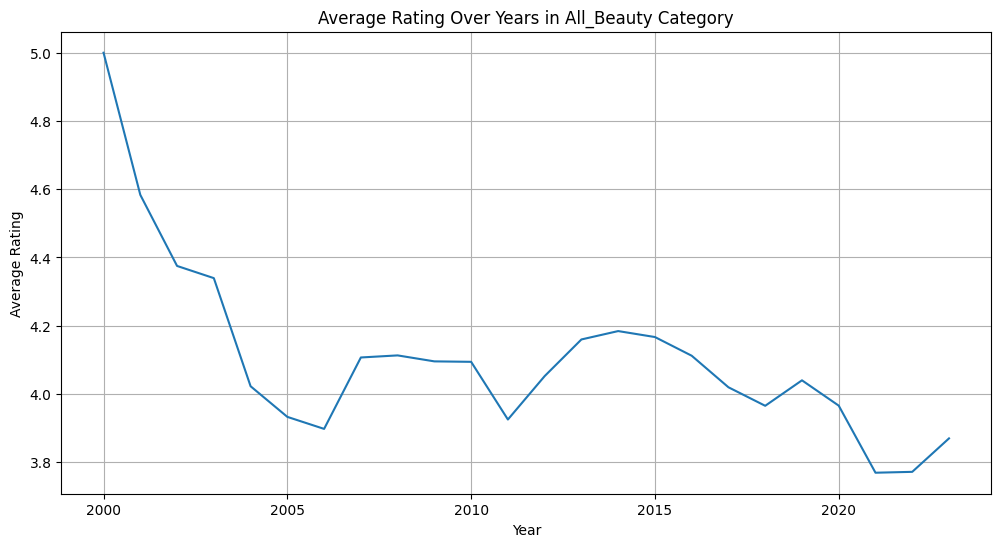

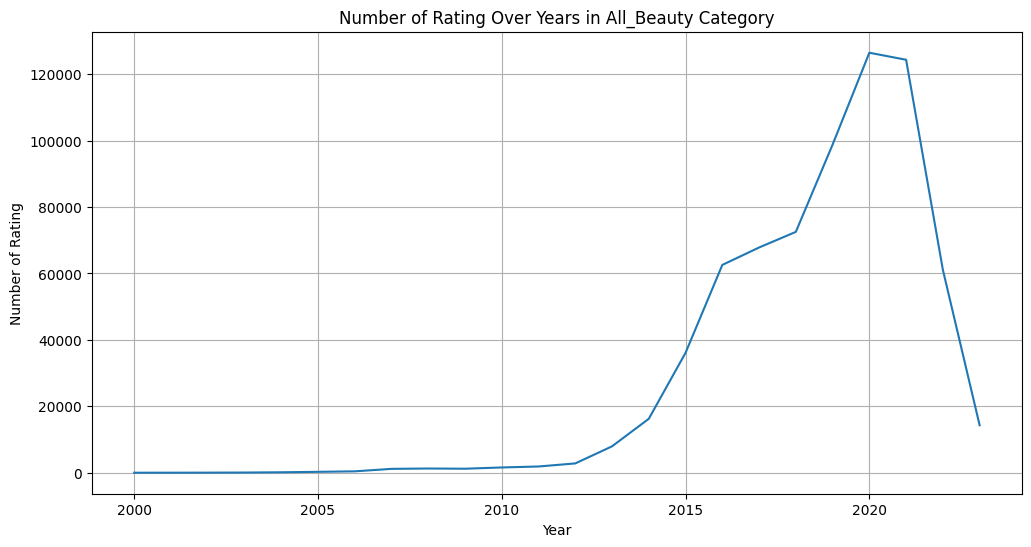

In [19]:
# convert 'datetime' column to datetime objects
full_All_Beauty_cat_df['datetime'] = pd.to_datetime(full_All_Beauty_cat_df['datetime'])
# extract time components
full_All_Beauty_cat_df['year'] = full_All_Beauty_cat_df['datetime'].dt.year
full_All_Beauty_cat_df['month'] = full_All_Beauty_cat_df['datetime'].dt.month
full_All_Beauty_cat_df['day_of_week'] = full_All_Beauty_cat_df['datetime'].dt.day_name()
full_All_Beauty_cat_df['hour'] = full_All_Beauty_cat_df['datetime'].dt.hour

# average rating by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='rating', data=full_All_Beauty_cat_df.groupby('year')['rating'].mean().reset_index())
plt.title('Average Rating Over Years in All_Beauty Category')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# number of total rating by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='rating', data=full_All_Beauty_cat_df.groupby('year')['rating'].count().reset_index())
plt.title('Number of Rating Over Years in All_Beauty Category')
plt.xlabel('Year')
plt.ylabel('Number of Rating')
plt.grid(True)
plt.show()